#Vorbereitung der Umgebung 
Bereitet die Umgebung vor, lädt die nötigen Dependencies und Libraries die im Projekt benötigt werden.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install shap
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=a724627695464fed4cf69fe42fd15b8a59b6e59fd685f019881e78e48b4702bd
  Stored in directory: /root/.cache/pip/wheels/7a/68/21/675239322d2bb2e8e1fa317d4bd7b5566a4e82780b25a27f7a
Successfully built pykalman


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

from scipy.ndimage import median_filter
from scipy.signal import wiener
from pykalman import KalmanFilter

In [4]:
#Code from https://github.com/phillipiv/rssi-filtering-kalman
#Used as a form of library import
def fft_filter(signal, N=8, M=2):

    """
    Implementation of Fourier filter.
    Takes a signal and filter parameters and return the filtered signal.
    input:
        - signal: signal to be filtered
        - N: window size of input signal
        - M: samples of fft signal to preserve (remember fft symmetry)
    output:
        - filtered signal
    """

    predicted_signal = []

    for j in range(0, np.shape(signal)[0], N):      # iterates on the entire signal, taking steps by N (window size)

        N = np.minimum(N, np.shape(signal)[0] - j)  # just in case we are at signal final and N samples are not avail

        R_0 = np.zeros(N)
        R_0[:] = signal[j:j+N]                       # saves in R_0 signal values of corresponding window size

        R_0_fft = np.fft.fft(R_0)                    # fft of signal window

        for k in range(int(N / 2)):                    # it keeps M samples of fft and sets the rest to zero
            R_0_fft[M+k] = 0                         # remember fft symmetry
            R_0_fft[-1-M-k] = 0

        R_0_ifft = np.fft.ifft(R_0_fft)              # inverse fft

        for i in range(0, N):
            predicted_signal.append(R_0_ifft[i])     # update predicted signal with this window calculation

    return predicted_signal


def kalman_block(x, P, s, A, H, Q, R):

    """
    Prediction and update in Kalman filter
    input:
        - signal: signal to be filtered
        - x: previous mean state
        - P: previous variance state
        - s: current observation
        - A, H, Q, R: kalman filter parameters
    output:
        - x: mean state prediction
        - P: variance state prediction
    """

    # check laaraiedh2209 for further understand these equations

    x_mean = A * x + np.random.normal(0, Q, 1)
    P_mean = A * P * A + Q

    K = P_mean * H * (1 / (H * P_mean * H + R))
    x = x_mean + K * (s - H * x_mean)
    P = (1 - K * H) * P_mean

    return x, P


def kalman_filter(signal, A, H, Q, R):

    """
    Implementation of Kalman filter.
    Takes a signal and filter parameters and returns the filtered signal.
    input:
        - signal: signal to be filtered
        - A, H, Q, R: kalman filter parameters
    output:
        - filtered signal
    """

    predicted_signal = []

    x = signal[0]                                 # takes first value as first filter prediction
    P = 0                                         # set first covariance state value to zero

    predicted_signal.append(x)
    for j, s in enumerate(signal[1:]):            # iterates on the entire signal, except the first element

        x, P = kalman_block(x, P, s, A, H, Q, R)  # calculates next state prediction

        predicted_signal.append(x)                # update predicted signal with this step calculation

    return predicted_signal

#Umwandlung JSON-Request zu CSV
Dieser Code muss nur ausgeführt werden, wenn die Erhebung von Referenzdaten statt mit dem Beacon Backend Projekt, mit hook.ubeac.io erfasst wurden. In diesem Codesegment werden die JSON-Files verarbeitet und die Informationen so aufbereitet, dass diese zu denselben CSV-Files führen wie bei dem Beacon Backend Projekt.

In [ ]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/"

whitelistMajorMinor = [100029571,100029586,100656666,1000411111,1000422222,1000454480,1230329194]

os.chdir(path+"JSON/")
dictionary_list = []

for jsonFile in glob.glob("*.json"):
  filename = os.path.splitext(jsonFile)[0]

  df = pd.read_json(path+"/JSON/"+filename+".json",)

  #Iterates through all gateway traces
  for traceIndex in range(len(df)):
    currentTrace = df.iloc[traceIndex]
    
    #Splits data string as it is not castable as json string
    #Two step is required to filter out , signs
    traceEntries = currentTrace.content.split('"')[3::2]
    for beaconIndex in range(len(traceEntries)):
      beaconData = traceEntries[beaconIndex].split(',')

      if len(beaconData[4]) >= 56: 
        #Extracts beacon data out of hex value
        beaconType = beaconData[4][6:18]
        uuid = beaconData[4][18:50]
        major = int(beaconData[4][50:54],16)
        minor = int(beaconData[4][54:58],16)
        majorminor = int(str(major)+str(minor))
        timestamp = beaconData[5]

        #Checks if current iteration should be skipped as signal is not of beacons
        if majorminor not in whitelistMajorMinor:
          continue
        #General signal power strength set for beacons
        measuredPower = -60

        #Specific power was set for beacon with below majorminor value
        if majorminor == 100656666:
          measuredPower = -75

        #Id of the tag of the Beacon
        tagId = beaconData[1]
        gateway = beaconData[2]
        rssi = int(beaconData[3])
        
        #Calculates distance with given formula
        distance = (10 ** ((measuredPower - rssi) / (10 * 3)))

        #Creates beacon entry as dictionary entry for efficent dataframe transformation
        beacon = {'_id':tagId, 'distance':distance, 'gateway':gateway, 
                'major':major, 'majorminor':majorminor, 'minor':minor, 
                'rssi':rssi, 'timestamp':timestamp,'type':beaconType,
                'uuid':uuid}
        #Adds beacon to dictionary
        dictionary_list.append(beacon)
#Transforms dicitonary to dataframe (more efficent then concat)
transformedDf = pd.DataFrame.from_dict(dictionary_list)

#Cleaning of dublicates / multi entries which were recived with same timestamp
transformedDf[["distance","rssi"]] = transformedDf.groupby(["timestamp","majorminor","gateway","uuid"])[["distance","rssi"]].transform('median')
transformedDf = transformedDf.drop_duplicates().sort_values(by=["timestamp","gateway"]).reset_index(drop=True)

transformedDf.to_csv(r''+path+"/CSV/CombinedGatewayData.csv", index=False)

#Labeling der Daten (Erweiterung CSV)
In diesem Abschnitt werden die CSV-Dateien welche aus JSON-Requests oder direkt aus einer Datenbank extrahiert wurden mit Labeln erweitert.
Hier zu muss ein LabelHelper.csv File ausgefüllt werden, da diese die Zeitpünkte / Timestamps enthalten man sich wann an welchem Punkt befunden hat um das entsprechende Label zu setzen.

In [ ]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/"
pathCSV = path+"CSV/"

#Contains timestamp, tag and specific tag values for each measurepoint of data
timestampLabelHeplerDf = pd.read_csv(path+"LabelHelper.csv",sep=";")

os.chdir(pathCSV)

frame = list()

for csvFile in glob.glob("*.csv"):
  df = pd.read_csv(pathCSV+csvFile)

  #This iterates through all data which are within the valid timestamp which are defined in a helper csv file
  for index in range(len(timestampLabelHeplerDf)):
    selection = df.loc[(df.timestamp >= timestampLabelHeplerDf.iloc[index].firsttimestamp) & 
                       (df.timestamp <= timestampLabelHeplerDf.iloc[index].lasttimestamp)].copy()
    selection[["tag","specificTag"]] = timestampLabelHeplerDf.iloc[index][["tag", "specificTag"]]
    frame.append(selection)
  
masterDf = pd.concat(frame).reset_index(drop=True)
masterDf.to_csv(r''+pathCSV+"LabeledCombinedGatewayData.csv", index=False)
masterDf.head()

,_id,distance,gateway,major,majorminor,minor,rssi,timestamp,type,uuid,tag,specificTag
0,F0F8F2044F23,0.980121,E06B09BAC79F,10004,1000422222,22222,-59.5,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1
1,DC0D300F720A,1.359356,E06B09BAC79F,12303,1230329194,29194,-64.0,1679222510,1AFF4C000215,D546DF97475747EFBE093E2DCBDD0C77,Room1,M1
2,C630A073DD08,1.107925,E06B09BAC79F,10002,100029586,9586,-60.0,1679222510,1AFF4C000215,0112233445566778899AABBCCDDEEFF0,Room1,M1
3,087CBF000028,1.847850,E06B09BAC79F,10004,1000411111,11111,-68.0,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1
4,04EE03C47286,0.857696,E06B09BAC79F,10004,1000454480,54480,-58.0,1679222510,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room1,M1


#Dateneinlesung, -analyse
In diesem Abschnitt werden die grob aufbereiten Daten eingelesen und visuell aufbereitet um dies zu analysieren.

In [5]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
features = ["distance","rssi","gateway"]
joinParameter = ["type","uuid","tag","specificTag","timestamp","major","majorminor","minor"]

#Training
filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv"
#Test closed Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv"
#Test open Doors
#filepath = "/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv"


masterDf = pd.read_csv(filepath)

#Dinamical adapting on number of gateways used for experiment
gateways = masterDf.gateway.unique()

#Creating new Dataframes
adaptedMasterDf = pd.DataFrame()
tempDf = pd.DataFrame()

#Repeat until every Timestamp and Gateway have combined / adapted to oneanother
for gateway in gateways:
  beaconMeasurementsOfGatewayDf = masterDf.loc[(masterDf.gateway == gateway)].copy()
  #Columns which could be used as feature are expanded with Name of Gateway as suffix
  beaconMeasurementsOfGatewayDf.columns = [col + '_' + gateway if col in features else col for col in beaconMeasurementsOfGatewayDf.columns]
    
  #Checks if temp Dataframe already has entries and has to be merged or a copy is "dumped" in
  if len(tempDf) > 0:
    tempDf = pd.merge(tempDf,beaconMeasurementsOfGatewayDf, how='outer', on=joinParameter)
  else:
    tempDf = beaconMeasurementsOfGatewayDf.copy()
adaptedMasterDf = pd.concat([adaptedMasterDf, tempDf])
adaptedMasterDf.drop_duplicates(inplace=True)
tempDf.drop(tempDf.index , inplace=True)
adaptedMasterDf.reset_index(drop=True, inplace=True)

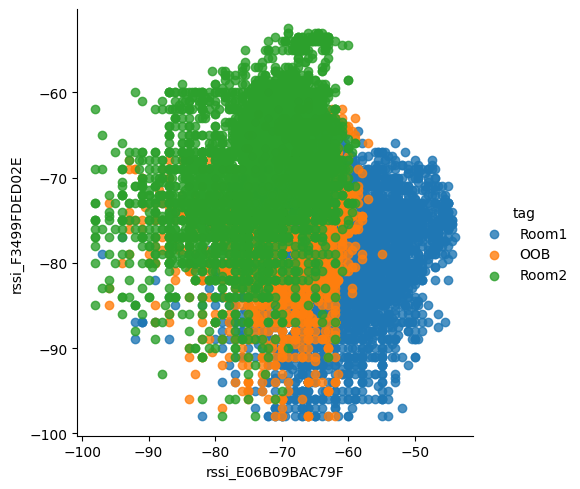

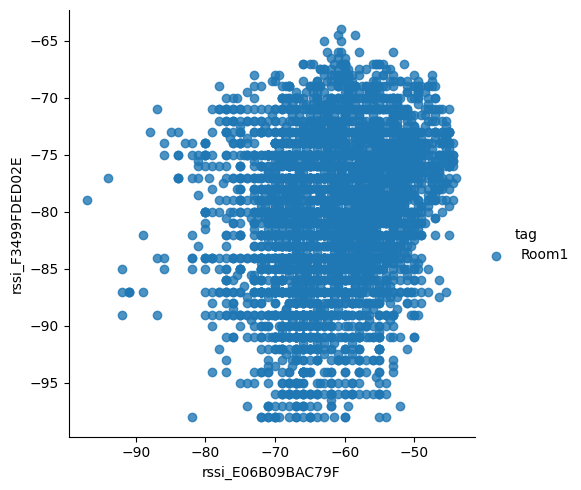

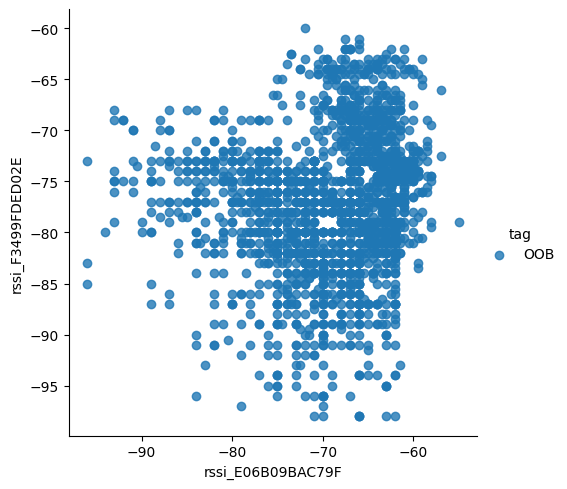

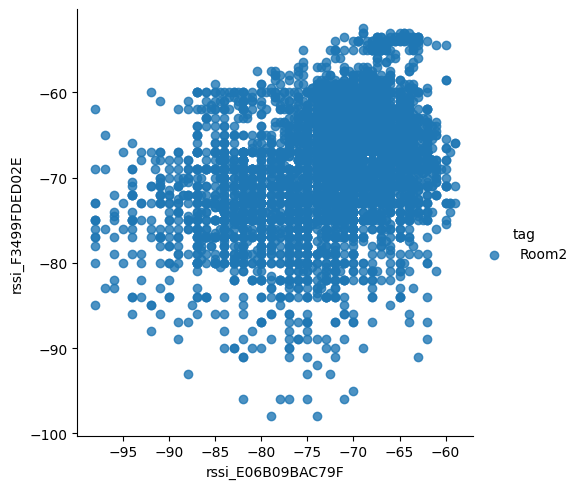

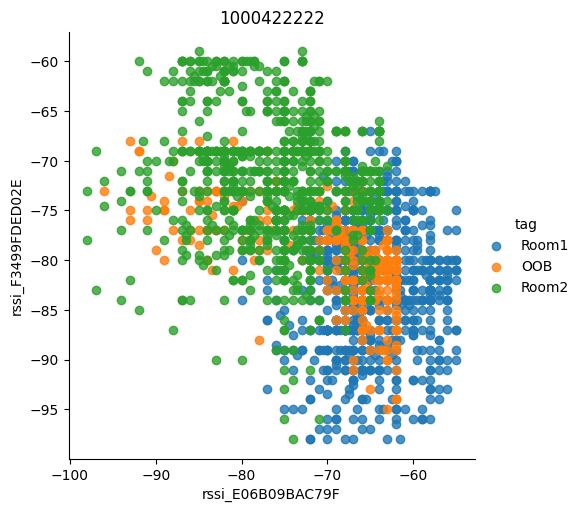

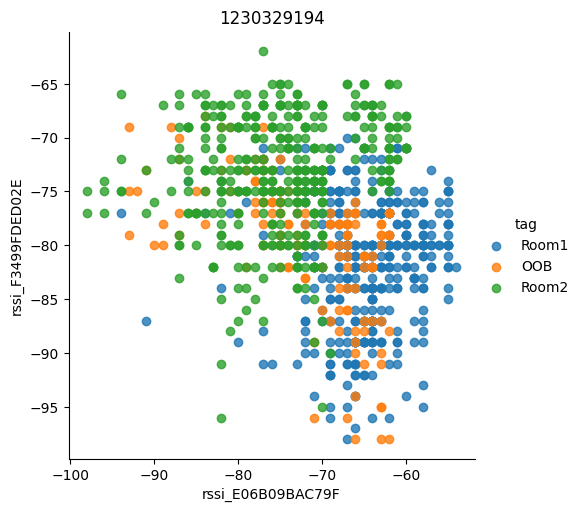

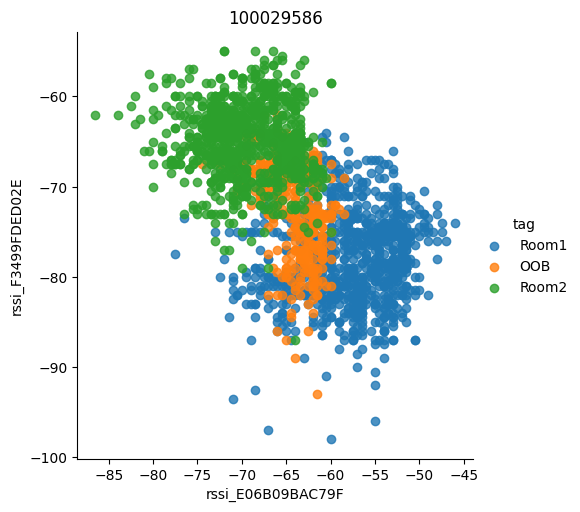

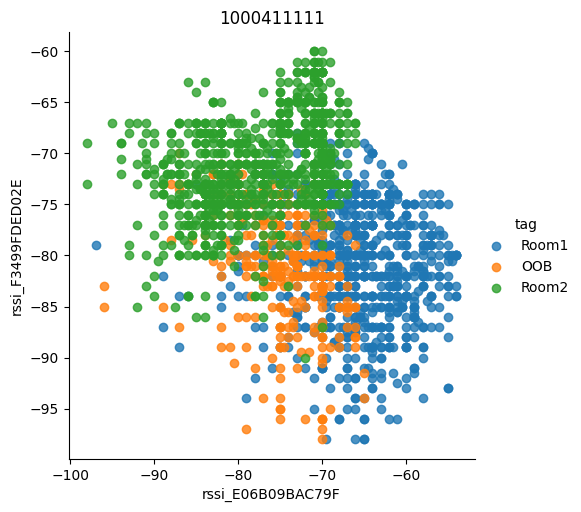

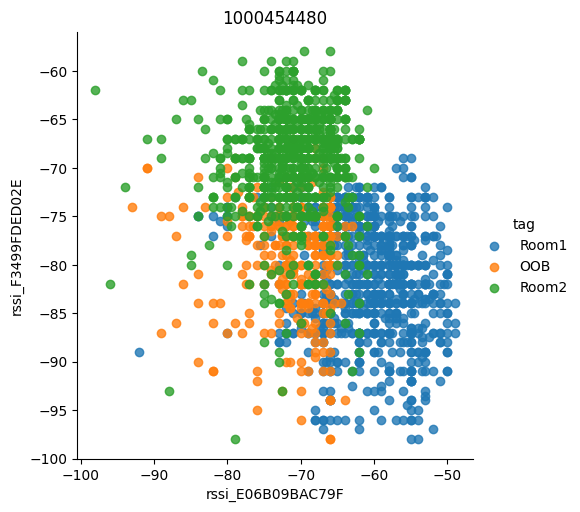

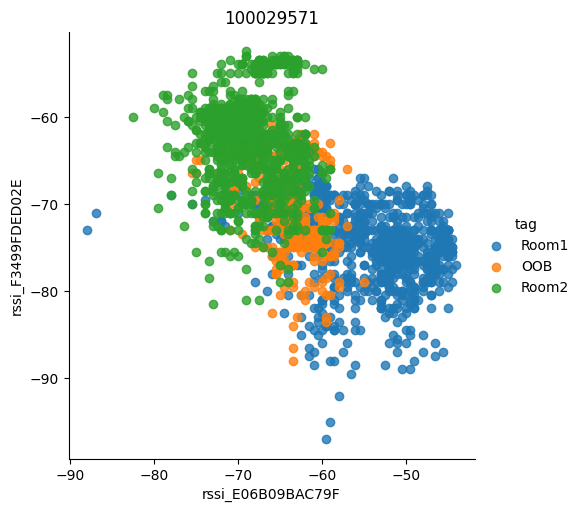

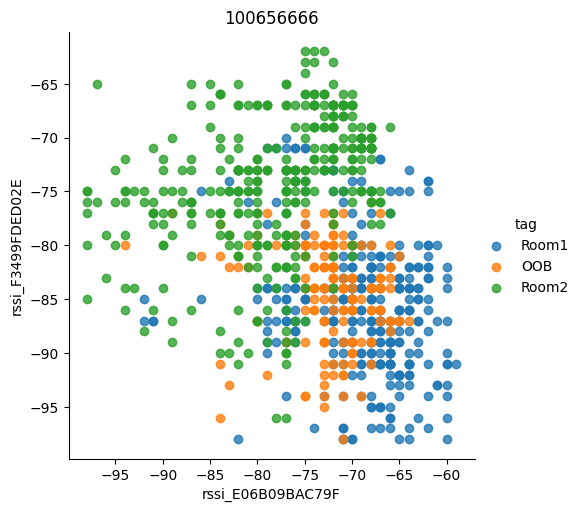

In [6]:
#Selects all columns that start with rssi
rssi_column_names = [column for column in adaptedMasterDf.columns if column.startswith('rssi')]

sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=adaptedMasterDf, hue='tag', fit_reg=False)
for tag in adaptedMasterDf.tag.unique():
  sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=adaptedMasterDf.loc[adaptedMasterDf.tag==tag], hue='tag', fit_reg=False)

plt.show()

for majorminor in adaptedMasterDf.majorminor.unique():
  df = adaptedMasterDf.loc[adaptedMasterDf.majorminor == majorminor]
  sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=df, hue='tag', fit_reg=False)
  plt.title(majorminor)
  
plt.show()
#for tag in adaptedMasterDf.tag.unique():
#  df = adaptedMasterDf.loc[adaptedMasterDf.tag == tag]
#  sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=df, hue='specificTag', fit_reg=False)
#  plt.show()

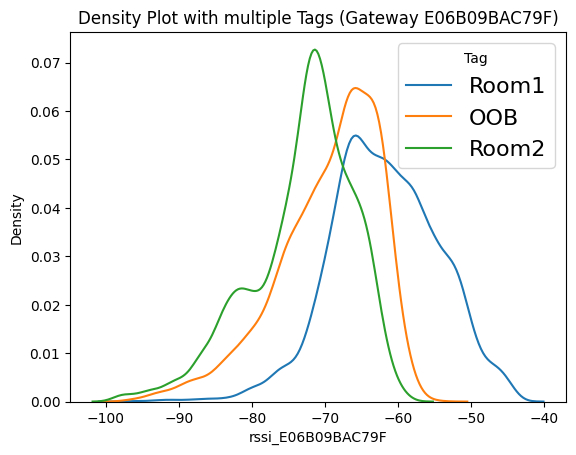

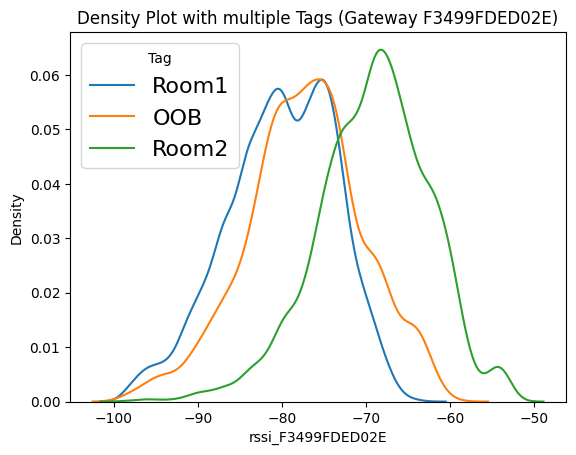

In [7]:
#Gets all tags (can be modified to spefic tags etc)
tags = adaptedMasterDf.tag.unique()
#Selects all columns that start with rssi
rssi_column_names = [column for column in adaptedMasterDf.columns if column.startswith("rssi")]

for rssi_column in rssi_column_names:
  #Iterates through the tags
  for tag in tags:
    #Subset to the specific tag
    subset = adaptedMasterDf[adaptedMasterDf['tag'] == tag]
    
    #Draw density plot
    sns.kdeplot(subset[rssi_column], label = tag)
    
  #Plot formatting
  plt.legend(prop={'size': 16}, title = 'Tag')
  plt.title('Density Plot with multiple Tags (Gateway '+rssi_column.split('_')[1]+')')
  plt.xlabel(rssi_column)
  plt.ylabel('Density')
  plt.show()

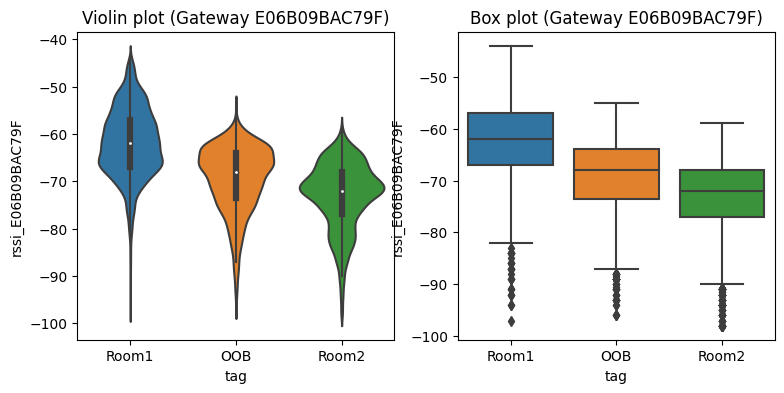

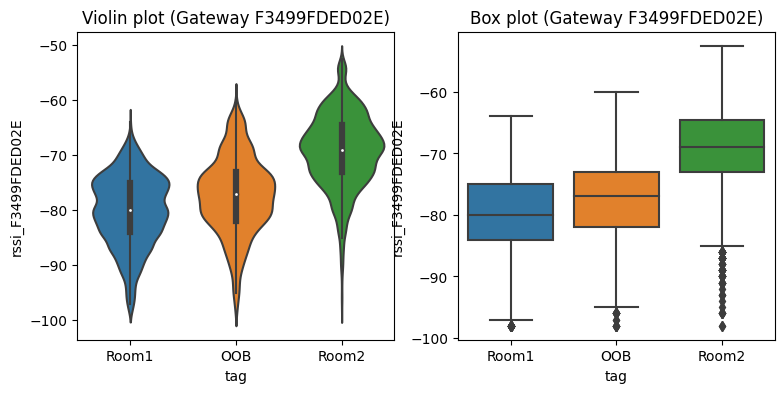

In [8]:
rssi_column_names = [column for column in adaptedMasterDf.columns if column.startswith("rssi")]

for rssi_column in rssi_column_names:
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
  
  #Plot violin plot
  asdf = sns.violinplot(ax=axs[0], x='tag', y=rssi_column, data=adaptedMasterDf)
  axs[0].set_title('Violin plot (Gateway '+rssi_column.split('_')[1]+')')

  #Plot box plot
  sns.boxplot(ax=axs[1], x='tag', y=rssi_column, data=adaptedMasterDf)
  axs[1].set_title('Box plot (Gateway '+rssi_column.split('_')[1]+')')

  plt.show()

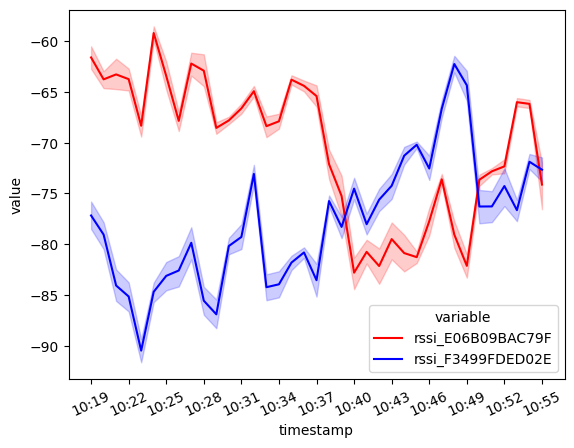

In [9]:
majorminor = adaptedMasterDf.majorminor.unique()
df = adaptedMasterDf.loc[adaptedMasterDf.majorminor == majorminor[0],(rssi_column_names + ["timestamp"])]
df.timestamp = pd.to_datetime(df.timestamp,unit='s').dt.strftime('%H:%M')
sample = sns.lineplot(x='timestamp', y='value', hue='variable', 
             data=pd.melt(df, ['timestamp']),
             palette=['red', 'blue'])
             #estimator="median")
sample.set_xticks(sample.get_xticks()[::3])
sample.set_xticklabels(sample.get_xticklabels(), rotation=25)
plt.show()

#Datenfilterung, -aufbereitung und non Machine Learning Ansatz
In diesem Bereich werden unterschiedliche Filter für die Datenaufbereitung genutzt und verglichen. Anhand diesen Filtern soll auch eine erste **non** Machine Learning Modell erstellt werden. Dies kann auch für die darauffolgenden Modellen als Benchmark verwendet werden.

In [10]:
#Moving median filter
window_size = 10

rssi_moving_median = [column + '_MMedian' for column in rssi_column_names]
rssi_moving_mean = [column + '_MMean' for column in rssi_column_names]
rssi_wiener = [column + '_Wiener' for column in rssi_column_names]
rssi_kalman = [column + '_Kalman' for column in rssi_column_names]

dict_filter_rssi_columns = {'MMedian': rssi_moving_median, 'MMean': rssi_moving_mean,
                     'Wiener': rssi_wiener, 'Kalman': rssi_kalman}

filteredDf = adaptedMasterDf.copy()

for majorminor in filteredDf.majorminor.unique():
  df = filteredDf.loc[(filteredDf.majorminor == majorminor), rssi_column_names]
  #Moving Median filter
  arrayRSSIMovingMedian = df.rolling(window=window_size).median().to_numpy()
  filteredDf.loc[(filteredDf.majorminor == majorminor), rssi_moving_median] = arrayRSSIMovingMedian
  #Sliding Window / moving mean filter
  arrayRSSIMovingMean = df.rolling(window=window_size).mean().to_numpy()
  filteredDf.loc[(filteredDf.majorminor == majorminor), rssi_moving_mean] = arrayRSSIMovingMean
  
  for index in range(len(rssi_column_names)):
    dfNoNAN = df.loc[(df.loc[:,rssi_column_names[index]].notnull()) ,rssi_column_names[index]]
    #Wiener Filter
    arrayRSSIWiener = wiener(dfNoNAN.to_numpy(),mysize=window_size)
    filteredDf.loc[(filteredDf.majorminor == majorminor) & filteredDf.loc[:,rssi_column_names[index]].notnull(), rssi_wiener[index]] = arrayRSSIWiener
  
    #Kalman filter
    #Uses standard setting and EM algorithmen to optimize em variables such as via .em function
    #transition_covariance, observation_covariance, initial_state_mean and initial_state_covariance
    kf = KalmanFilter()
    #n_iter prevents overfitting of EM fitting and smooth predicts rssi values
    #[0][:,0] selects the predicted rssi values of the returned array
    arrayRSSIKalman = kf.em(dfNoNAN, n_iter=5).smooth(dfNoNAN)[0][:,0]
    filteredDf.loc[(filteredDf.majorminor == majorminor) & filteredDf.loc[:,rssi_column_names[index]].notnull(), rssi_kalman[index]] = arrayRSSIKalman

divide by zero encountered in true_divide
invalid value encountered in multiply
divide by zero encountered in true_divide
invalid value encountered in multiply
divide by zero encountered in true_divide
invalid value encountered in multiply


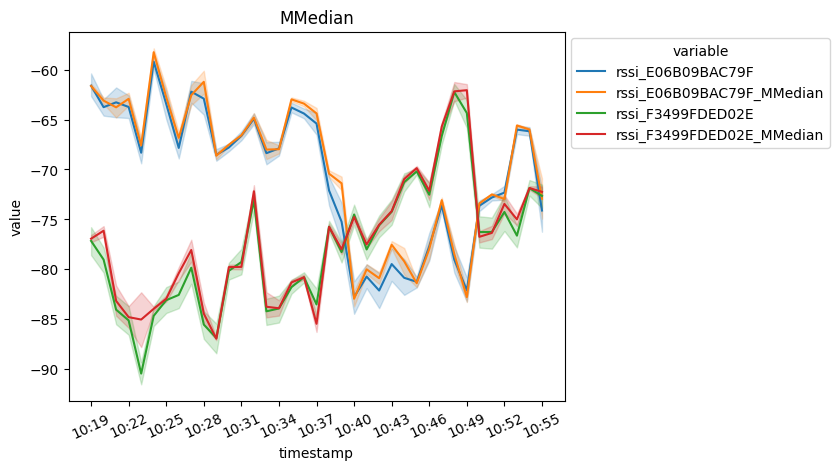

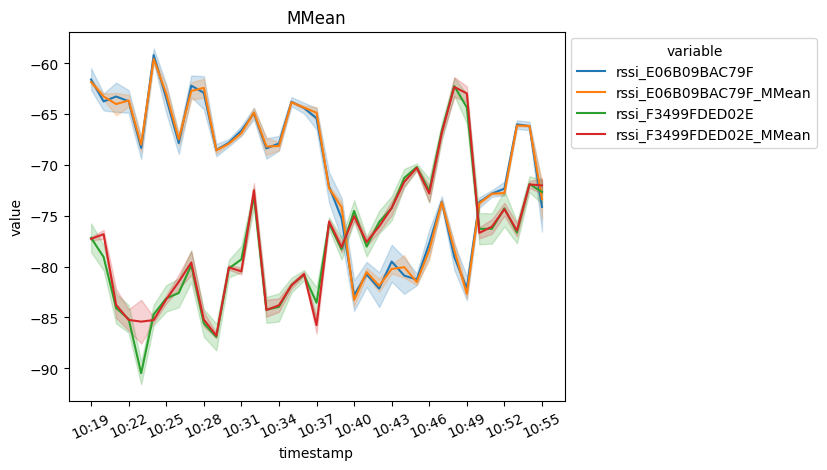

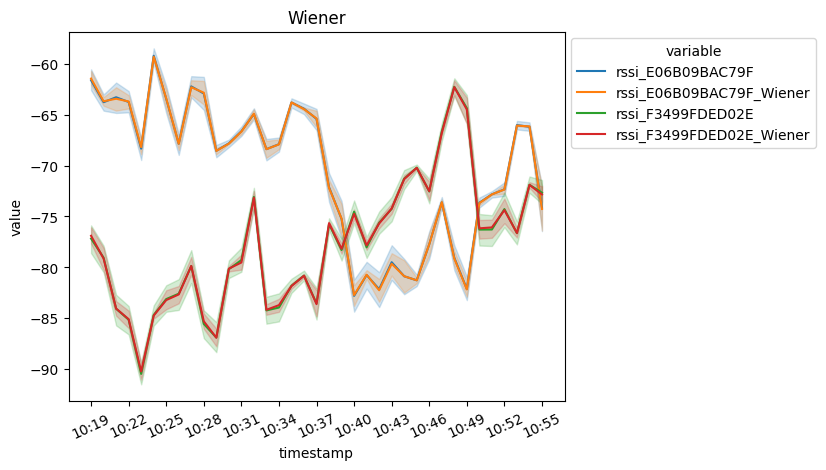

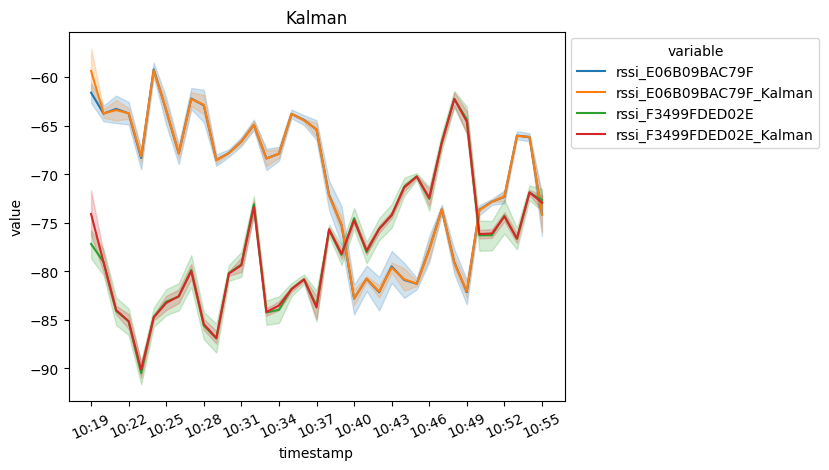

In [11]:
#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
for key in dict_filter_rssi_columns.keys():
  #Checks for valid values before creating plot otherwise it skips the current dictionary entry
  if len(dict_filter_rssi_columns.get(key, [])) < 2:
    print('Invalid number of columns in dictionary "dict_rssi_columns" for key: '+key)
    continue

  majorminor = filteredDf.majorminor.unique()
  columnSelection = (rssi_column_names + dict_filter_rssi_columns.get(key) + ['timestamp'])
  df = filteredDf.loc[filteredDf.majorminor == majorminor[0],columnSelection]
  df.timestamp = pd.to_datetime(df.timestamp,unit='s').dt.strftime('%H:%M')
  df = pd.melt(df, ['timestamp']).sort_values(['timestamp','variable'])
  ax = sns.lineplot(x='timestamp', y='value', hue='variable', 
				data=df)
  plt.title(key)
  ax.set_xticks(ax.get_xticks()[::3])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
  plt.show()


In [12]:
all_rssi_columns = [column for column in filteredDf.columns if column.startswith("rssi")]
test = filteredDf.copy()
test.timestamp = pd.to_datetime(test.timestamp,unit='s').dt.strftime('%H:%M')
test.groupby(["tag","uuid"])[["timestamp"]+all_rssi_columns].agg(["min","max"])

timestamp        rssi_E06B09BAC79F  \
                                             min    max               min   
tag   uuid                                                                  
OOB   0112233445566778899AABBCCDDEEFF0     10:34  10:40             -75.5   
      D546DF97475747EFBE093E2DCBDD0C77     10:34  10:40             -94.0   
      FDA50693A4E24FB1AFCFC6EB07647825     10:34  10:40             -96.0   
Room1 0112233445566778899AABBCCDDEEFF0     10:19  10:34             -88.0   
      D546DF97475747EFBE093E2DCBDD0C77     10:19  10:34             -94.0   
      FDA50693A4E24FB1AFCFC6EB07647825     10:19  10:34             -97.0   
Room2 0112233445566778899AABBCCDDEEFF0     10:40  10:55             -86.5   
      D546DF97475747EFBE093E2DCBDD0C77     10:40  10:55             -98.0   
      FDA50693A4E24FB1AFCFC6EB07647825     10:40  10:55             -98.0   

                                             rssi_F3499FDED02E        \
                                         max               min   max   
tag   uuid                                                             
OOB   0112233445566778899AABBCCDDEEFF0 -55.0             -93.0 -60.0   
      D546DF97475747EFBE093E2DCBDD0C77 -62.0             -98.0 -68.0   
      FDA50693A4E24FB1AFCFC6EB07647825 -61.0             -98.0 -67.0   
Room1 0112233445566778899AABBCCDDEEFF0 -44.0             -98.0 -64.0   
      D546DF97475747EFBE093E2DCBDD0C77 -54.0             -98.0 -70.0   
      FDA50693A4E24FB1AFCFC6EB07647825 -49.0             -98.0 -67.0   
Room2 0112233445566778899AABBCCDDEEFF0 -59.0             -87.0 -52.5   
      D546DF97475747EFBE093E2DCBDD0C77 -59.0             -96.0 -62.0   
      FDA50693A4E24FB1AFCFC6EB07647825 -60.0             -98.0 -58.0   

                                       rssi_E06B09BAC79F_MMedian         \
                                                             min    max   
tag   uuid                                                                
OOB   0112233445566778899AABBCCDDEEFF0                    -72.25 -50.25   
      D546DF97475747EFBE093E2DCBDD0C77                    -81.50 -64.50   
      FDA50693A4E24FB1AFCFC6EB07647825                    -87.50 -60.00   
Room1 0112233445566778899AABBCCDDEEFF0                    -71.75 -44.50   
      D546DF97475747EFBE093E2DCBDD0C77                    -72.00 -56.00   
      FDA50693A4E24FB1AFCFC6EB07647825                    -77.50 -50.00   
Room2 0112233445566778899AABBCCDDEEFF0                    -77.00 -60.50   
      D546DF97475747EFBE093E2DCBDD0C77                    -85.00 -61.00   
      FDA50693A4E24FB1AFCFC6EB07647825                    -95.50 -63.75   

                                       rssi_F3499FDED02E_MMedian         ...  \
                                                             min    max  ...   
tag   uuid                                                               ...   
OOB   0112233445566778899AABBCCDDEEFF0                    -81.25 -63.00  ...   
      D546DF97475747EFBE093E2DCBDD0C77                    -86.50 -70.50  ...   
      FDA50693A4E24FB1AFCFC6EB07647825                    -91.50 -72.00  ...   
Room1 0112233445566778899AABBCCDDEEFF0                    -87.25 -66.25  ...   
      D546DF97475747EFBE093E2DCBDD0C77                    -91.00 -71.00  ...   
      FDA50693A4E24FB1AFCFC6EB07647825                    -94.00 -69.00  ...   
Room2 0112233445566778899AABBCCDDEEFF0                    -75.25 -53.50  ...   
      D546DF97475747EFBE093E2DCBDD0C77                    -79.00 -66.50  ...   
      FDA50693A4E24FB1AFCFC6EB07647825                    -85.50 -60.00  ...   

                                       rssi_F3499FDED02E_MMean         \
                                                           min    max   
tag   uuid                                                              
OOB   0112233445566778899AABBCCDDEEFF0                  -81.30 -62.90   
      D546DF97475747EFBE093E2DCBDD0C77                  -86.50 -71.50   
      FDA50693A4E24FB1

#Machine Learning Algorithmen Training
Beinhaltet die unterschiedlichen Machine Learning Ansätze, welche für die Trainingsdatensätze geprüft werden.

Geplant: KNN, Naive Bayes, Support Vector Classifier (SVC) und Random Forest Classifier

In [18]:
#Set answer to every question as random state (as it is a number used for randomization)
random_state=42
#Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
dict_best_accuaracy = dict()

Text(0.5, 1.0, 'Accuracy with different number of neighbors')

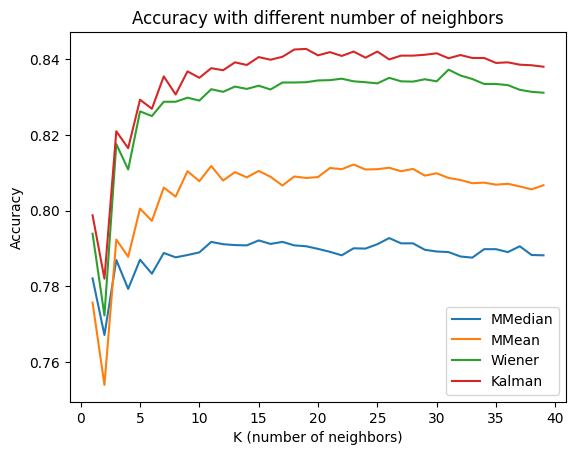

In [21]:
#Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
dict_accuaracy = dict.fromkeys(dict_filter_rssi_columns.keys(), [])
dict_best_accuaracy["knn"] = dict.fromkeys(dict_filter_rssi_columns.keys(), [])
k = []

#Check different number of neighbors
for n_neighbors in range(1, 40):
    #Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    k.append(n_neighbors)

    for key in dict_filter_rssi_columns.keys():
      #Checks for valid values before creating plot otherwise it skips the current dictionary entry
      if len(dict_filter_rssi_columns.get(key, [])) < 2:
        print('Invalid number of columns in dictionary "dict_rssi_columns" for key: '+key)
        continue

      X = filteredDf.loc[:,dict_filter_rssi_columns.get(key)].fillna(-1000)
      Y = filteredDf.tag

      kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

      crossv_results = cross_val_score(knn, X, Y, cv=kfold, scoring='accuracy')

      #Append entry to list
      dict_accuaracy[key] = dict_accuaracy[key] + [crossv_results.mean()]

      if (len(dict_best_accuaracy["knn"][key])==0) or (dict_best_accuaracy["knn"][key]["best_score_"] < [crossv_results.mean()]) :
        dict_best_accuaracy["knn"][key] = {"best_score_": [crossv_results.mean()],
                                           "best_params_": {"n_neighbors": n_neighbors}}

for key in dict_accuaracy.keys():
  plt.plot(k, dict_accuaracy[key])
plt.ylabel("Accuracy")
plt.xlabel("K (number of neighbors)")
plt.legend(dict_filter_rssi_columns.keys(), loc='lower right')
plt.title("Accuracy with different number of neighbors")

In [22]:
dict_best_accuaracy["svm"] = dict.fromkeys(dict_filter_rssi_columns.keys(), [])

#Set up possible values of parameters to optimize over
param_svm_grid = { 'C': [10, 100], 'gamma': [0.1, 0.01]}#, 'kernel': ['rbf','linear','sigmoid'] }

#SVM model
svm = SVC(kernel='rbf')

#Loop for each filter technique
for key in dict_filter_rssi_columns.keys():
  #Checks for valid values before creating plot otherwise it skips the current dictionary entry
  if len(dict_filter_rssi_columns.get(key, [])) < 2:
    print('Invalid number of columns in dictionary "dict_rssi_columns" for key: '+key)
    continue

  sc = StandardScaler()
  X = filteredDf.loc[:,dict_filter_rssi_columns.get(key)].fillna(-1000)
  Y = filteredDf.tag

  X = sc.fit_transform(X)

  kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

  #Non_nested parameter search and scoring
  svm_grid = GridSearchCV(estimator=svm, param_grid=param_svm_grid, cv=kfold)
  #RandomizedSearchCV(estimator=svm, param_grid=param_svm_grid, cv=kfold, random_state=random_state, n_iter=10)
  #GridSearchCV(estimator=svm, param_grid=param_svm_grid, cv=kfold)
  svm_grid.fit(X, Y)

  print(key)
  print(svm_grid.best_score_)
  print(svm_grid.best_params_)
  dict_best_accuaracy["svm"][key] = {"best_score_": svm_grid.best_score_,
                                     "best_params_": svm_grid.best_params_}

#Result (Parameter Optimization with)
#param_svm_grid = { 'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001] }
#'kernel': 'rbf'
#MMedian
#0.7800326251463491
#{'gamma': 0.1, 'C': 100}
#MMean
#0.7734739831710404
#{'gamma': 0.1, 'C': 100}
#Wiener
#0.7887512255251912
#{'gamma': 0.1, 'C': 100}
#Kalman
#0.7927627978145197
#{'gamma': 0.1, 'C': 100}

#Result (Parameter Optimization with)
#param_svm_grid = { 'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001] }
#'kernel': 'sigmoid'
#MMedian
#0.477742320835356
#{'C': 0.1, 'gamma': 0.01}
#MMean
#0.477742320835356
#{'C': 0.1, 'gamma': 0.01}
#Wiener
#0.4290585705854917
#{'C': 0.1, 'gamma': 0.1}
#Kalman
#0.4290585705854917
#{'C': 0.1, 'gamma': 0.1}

MMedian
0.7800326251463491
{'C': 100, 'gamma': 0.1}
MMean
0.7734739831710404
{'C': 100, 'gamma': 0.1}
Wiener
0.7887512255251912
{'C': 100, 'gamma': 0.1}
Kalman
0.7927627978145197
{'C': 100, 'gamma': 0.1}


In [23]:
dict_best_accuaracy["nbayes"] = dict.fromkeys(dict_filter_rssi_columns.keys(), [])

#Naive Bayes
param_grid_nb = { 'var_smoothing': np.logspace(0,-9, num=100) }

gnb = GaussianNB()

#Loop for each filter technique
for key in dict_filter_rssi_columns.keys():
  #Checks for valid values before creating plot otherwise it skips the current dictionary entry
  if len(dict_filter_rssi_columns.get(key, [])) < 2:
    print('Invalid number of columns in dictionary "dict_rssi_columns" for key: '+key)
    continue

  X = filteredDf.loc[:,dict_filter_rssi_columns.get(key)].fillna(-1000)
  Y = filteredDf.tag

  kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

  #Non_nested parameter search and scoring
  gnb_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=kfold)
  gnb_grid.fit(X, Y)

  print(key)
  print(gnb_grid.best_score_)
  print(gnb_grid.best_params_)
  dict_best_accuaracy["nbayes"][key] = {"best_score_": gnb_grid.best_score_,
                                        "best_params_": gnb_grid.best_params_}

MMedian
0.477742320835356
{'var_smoothing': 1.0}
MMean
0.477742320835356
{'var_smoothing': 1.0}
Wiener
0.4290585705854917
{'var_smoothing': 1.0}
Kalman
0.4290585705854917
{'var_smoothing': 1.0}


In [24]:
dict_best_accuaracy["rforest"] = dict.fromkeys(dict_filter_rssi_columns.keys(), [])

#Random Forest Classifier
n_estimators = [1200, 1500]
max_depth = [15, 30]

param_grid_rf = dict(n_estimators = n_estimators, max_depth = max_depth)

rf = RandomForestClassifier(random_state = random_state)

#Loop for each filter technique
for key in dict_filter_rssi_columns.keys():
  #Checks for valid values before creating plot otherwise it skips the current dictionary entry
  if len(dict_filter_rssi_columns.get(key, [])) < 2:
    print('Invalid number of columns in dictionary "dict_rssi_columns" for key: '+key)
    continue

  X = filteredDf.loc[:,dict_filter_rssi_columns.get(key)].fillna(-1000)
  Y = filteredDf.tag

  kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)

  #Non_nested parameter search and scoring
  #rf_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=kfold, random_state=random_state, n_iter=5)
  rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=kfold)
  rf_grid.fit(X, Y)

  print(key)
  print(rf_grid.best_score_)
  print(rf_grid.best_params_)
  dict_best_accuaracy["rforest"][key] = {"best_score_": rf_grid.best_score_,
                                         "best_params_": rf_grid.best_params_}

#Result (Parameter Optimization with)
#n_estimators = [500, 1000, 1200, 1500]
#max_depth = [15, 20, 30, 35]

#MMedian
#0.8334233191926984
#{'max_depth': 30, 'n_estimators': 1500}
#MMean
#0.8041816047954369
#{'max_depth': 15, 'n_estimators': 1200}
#Wiener
#0.8303370482257548
#{'max_depth': 15, 'n_estimators': 1500}
#Kalman
#0.8320338054020082
#{'max_depth': 15, 'n_estimators': 1200}

MMedian
0.8334233191926984
{'max_depth': 30, 'n_estimators': 1500}
MMean
0.8041816047954369
{'max_depth': 15, 'n_estimators': 1200}
Wiener
0.8303370482257548
{'max_depth': 15, 'n_estimators': 1500}
Kalman
0.8320338054020082
{'max_depth': 15, 'n_estimators': 1200}


#Performanceanalyse, Bildliche Aufbereitung
In diesem Abschnitt werden die Modellem mit den ermittelten optimalen Hyperparameter analysiert und aufgezeigt.

Dazu werden Confusionsmatrizen und ROC Curves erstellt.

In [25]:
dict_best_accuaracy
#With this the above "Machine Learning Algorithmen Training" can be ignored as it is used to finde the fitting hyperparameter
#dict_best_accuaracy = {'knn': {'MMedian': {'best_score_': [0.7927625598484632],
#   'best_params_': {'n_neighbors': 26}},
#  'MMean': {'best_score_': [0.8122056954795968],
#   'best_params_': {'n_neighbors': 23}},
#  'Wiener': {'best_score_': [0.8372805358043729],
#   'best_params_': {'n_neighbors': 31}},
#  'Kalman': {'best_score_': [0.842758395442474],
#   'best_params_': {'n_neighbors': 19}}},
# 'svm': {'MMedian': {'best_score_': 0.7800326251463491,
#   'best_params_': {'C': 100, 'gamma': 0.1}},
#  'MMean': {'best_score_': 0.7734739831710404,
#   'best_params_': {'C': 100, 'gamma': 0.1}},
#  'Wiener': {'best_score_': 0.7887512255251912,
#   'best_params_': {'C': 100, 'gamma': 0.1}},
#  'Kalman': {'best_score_': 0.7927627978145197,
#   'best_params_': {'C': 100, 'gamma': 0.1}}},
# 'nbayes': {'MMedian': {'best_score_': 0.477742320835356,
#   'best_params_': {'var_smoothing': 1.0}},
#  'MMean': {'best_score_': 0.477742320835356,
#   'best_params_': {'var_smoothing': 1.0}},
#  'Wiener': {'best_score_': 0.4290585705854917,
#   'best_params_': {'var_smoothing': 1.0}},
#  'Kalman': {'best_score_': 0.4290585705854917,
#   'best_params_': {'var_smoothing': 1.0}}},
# 'rforest': {'MMedian': {'best_score_': 0.8334233191926984,
#   'best_params_': {'max_depth': 30, 'n_estimators': 1500}},
#  'MMean': {'best_score_': 0.8041816047954369,
#   'best_params_': {'max_depth': 15, 'n_estimators': 1200}},
#  'Wiener': {'best_score_': 0.8303370482257548,
#   'best_params_': {'max_depth': 15, 'n_estimators': 1500}},
#  'Kalman': {'best_score_': 0.8320338054020082,
#   'best_params_': {'max_depth': 15, 'n_estimators': 1200}}}}

{'knn': {'MMedian': {'best_score_': [0.7927625598484632],
   'best_params_': {'n_neighbors': 26}},
  'MMean': {'best_score_': [0.8122056954795968],
   'best_params_': {'n_neighbors': 23}},
  'Wiener': {'best_score_': [0.8372805358043729],
   'best_params_': {'n_neighbors': 31}},
  'Kalman': {'best_score_': [0.842758395442474],
   'best_params_': {'n_neighbors': 19}}},
 'svm': {'MMedian': {'best_score_': 0.7800326251463491,
   'best_params_': {'C': 100, 'gamma': 0.1}},
  'MMean': {'best_score_': 0.7734739831710404,
   'best_params_': {'C': 100, 'gamma': 0.1}},
  'Wiener': {'best_score_': 0.7887512255251912,
   'best_params_': {'C': 100, 'gamma': 0.1}},
  'Kalman': {'best_score_': 0.7927627978145197,
   'best_params_': {'C': 100, 'gamma': 0.1}}},
 'nbayes': {'MMedian': {'best_score_': 0.477742320835356,
   'best_params_': {'var_smoothing': 1.0}},
  'MMean': {'best_score_': 0.477742320835356,
   'best_params_': {'var_smoothing': 1.0}},
  'Wiener': {'best_score_': 0.4290585705854917,
   'b

In [ ]:

#Testing the model using X_test and storing the output in y_pred
y_pred = clf.predict(X_test)

#Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

#Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
